In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/CORONA_dataset_0-month_3-month-target_ifn (1).csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   grp                  1229 non-null   int64  
 1   init_group           1229 non-null   int64  
 2   age                  1228 non-null   float64
 3   gender               1229 non-null   int64  
 4   final_education      1229 non-null   int64  
 5   race_grp             1229 non-null   int64  
 6   ethnicity            1210 non-null   float64
 7   weight               1228 non-null   float64
 8   BMI                  1228 non-null   float64
 9   height               1229 non-null   int64  
 10  newsmoker            1229 non-null   int64  
 11  drinker              1229 non-null   int64  
 12  drinksperwk          1217 non-null   float64
 13  duration_ra          1225 non-null   float64
 14  ara_func_class       1229 non-null   int64  
 15  num_tnf              1229 non-null   i

In [4]:
columns_drop = df.isnull().mean()[df.isnull().mean() > 0.7].index
columns_drop
df = df.drop(['UNMC_id', 'CDate', 'futime', 'response_status', 'response_encoded', 'DAS_28_0', 'DAS_28_3' ], axis=1)
df = df.drop(columns_drop, axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()

columns_to_encode = ['grp', 'init_group', 'gender', 'newsmoker', 'drinker', 'ara_func_class', 'final_education', 'race_grp']

# Using .fit_transform function to fit label
for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])


In [6]:
df_1 = df

In [8]:
pip install hmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for hmm: filename=hmm-0.0.1-py3-none-any.whl size=1834 sha256=8bc93c5204463af431a593150686fab392bac23a87cf1b442fc1a631ba4698f2
  Stored in directory: /root/.cache/pip/wheels/37/c4/74/5a00f9f321a8a6eceb5cd90a7fa5ff4e2325ba9f9e1dba968b
Successfully built hmm


In [10]:
pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.9 MB/s eta 0:00:00


In [14]:
print(df[['Type I IFN activity', 'IFNβ activity final', 'IFNα activity final']].head())


KeyError: ignored

In [16]:
from hmmlearn import hmm



# Define the names of columns that need imputation
impute_cols = ['Type I IFN activity']

# Loop over each column with missing values
for col in impute_cols:
    # Create an HMM with two states (one for the missing value, one for the observed value)
    model = hmm.GaussianHMM(n_components=2, covariance_type="full")
    
    # Fit the model to the observed data in the column
    observed_data = df_1[col][~df_1[col].isna()].values.reshape(-1, 1)
    model.fit(observed_data)
    
    # Use the model to impute the missing values in the column
    missing_data_indices = df_1[df_1[col].isna()].index
    for idx in missing_data_indices:
        imputed_value = model.predict(df_1.iloc[idx, :].values.reshape(1, -1))[0]
        df_1.loc[idx, col] = observed_data[imputed_value][0]


In [17]:
df = df_1

In [18]:
from sklearn.impute import KNNImputer

# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=30)

# Impute missing values using KNN
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# df['response_encoded'] = df['response_encoded'].round().astype(int)


In [19]:
def calculate_DAS28_CRP_0(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28_0']) + 0.28*math.sqrt(
        row['swollen_jts_28_0']) + 0.014*row['pt_global_assess_0'] + 0.36*np.log(row['usresultsCRP_0']+1) + 0.96
    return DAS28_CRP

def calculate_DAS28_CRP_3(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28_3']) + 0.28*math.sqrt(
        row['swollen_jts_28_3']) + 0.014*row['pt_global_assess_3'] + 0.36*np.log(row['usresultsCRP_3']+1) + 0.96
    return DAS28_CRP

In [20]:
df['DAS_28_0'] = df.apply(calculate_DAS28_CRP_0, axis=1)
df['DAS_28_3'] = df.apply(calculate_DAS28_CRP_3, axis=1)

In [21]:
def responseClassify(row, baseline='DAS_28_0', next='DAS_28_3'):
    # set threshold
    lower_change = 0.6
    upper_change = 1.2
    change = row[baseline] - row[next]
    if change <= lower_change:
        return "No Response"
    elif (change <= upper_change) & (change > lower_change):
        if row[next] > 5.1:
            return "No Response"
        else:
            return "Moderate"
    elif change > upper_change:
        if row[next] > 3.2:
            return "Moderate"
        else:
            return "Good"
    else:
        return "Unknown"

In [22]:
df['response_status'] = df.apply(responseClassify, axis=1)


In [23]:
value_counts = df['response_status'].value_counts()
print(value_counts)

Moderate       450
No Response    407
Good           372
Name: response_status, dtype: int64


In [24]:
encoding_mapping = {'Moderate': 2, 'Good': 3, 'No Response': 1}

# Apply manual encoding and store the result in a new column
df['response_encoded'] = df['response_status'].map(encoding_mapping)

In [25]:
df = df.drop(['tender_jts_28_3', 'swollen_jts_28_3', 'pt_global_assess_3', 'usresultsCRP_3', 'DAS_28_0', 'DAS_28_3', 'weight', 'pt_pain', 'ccpstatus_b', 'response_status' ], axis=1)

In [ ]:
# df = df.fillna(df.median())

<ipython-input-47-a187aa03e3ee>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.median())


In [26]:
!pip install h2o
import h2o
h2o.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.40.0.4-py2.py3-none-any.whl size=177697886 sha256=0c9755a0de3da610e68e45693d1b0364d097ccd94ad73743eaf186429b92dd98
  Stored in directory: /root/.cache/pip/wheels/43/f2/b0/5bb4d702a0467e82d77c45088db3eef25114c26b0eec8e7f6a
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpj0a0s31u
  JVM stdout: /tmp/tm

--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.4
H2O_cluster_version_age:    13 days
H2O_cluster_name:           H2O_from_python_unknownUser_2ixup2
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.172 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.11 final
--------------------------  -----------------------------------------------------------------------------------------

In [27]:
h2o_df = h2o.H2OFrame(df)

#preview
h2o_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


grp    init_group    age    gender    final_education    race_grp    ethnicity      BMI    height    newsmoker    drinker    drinksperwk    duration_ra    ara_func_class    num_tnf    num_nontnf    ndmardused    rfstatus_b    usresultsRF    usresultsCCP3    hxmi    hxunstab_ang    hxchf    hxother_cv    hxtia    hxstroke    hxcopd    hxhtn    hxdiabetes    hxhld    hx_anycancer    seatedbp1    seatedbp2    pres_mtx    pres_arava    pres_azulfidine    pres_plaquenil    pres_imuran    pres_minocin    pres_pred    nonpresNSAIDs_use    NSAIDs_use    md_global_assess        di    usresultsIgA    usresultsIgG    usresultsIgM    tender_jts_28_0    swollen_jts_28_0    pt_global_assess_0    usresultsCRP_0    Type I IFN activity    response_encoded
-----  ------------  -----  --------  -----------------  ----------  -----------  -------  --------  -----------  ---------  -------------  -------------  ----------------  ---------  ------------  ------------  ------------  -------------  ---------------  ------  --------------  -------  ------------  -------  ----------  --------  -------  ------------  -------  --------------  -----------  -----------  ----------  ------------  -----------------  ----------------  -------------  --------------  -----------  -------------------  ------------  ------------------  --------  --------------  --------------  --------------  -----------------  ------------------  --------------------  ----------------  ---------------------  ------------------
    4             0     59         0                  0           7     0.966667  33.9829        64            0          0       0                    11                 1          3      1                    3             1           18.2               19       0               0        0             0        0           0         0        1             0        0               0          128           82           0             0                  0                 0              0               0            0                    1             0                  50  1.375                207             826              24                 27                   6                    55             17.13                      0                   2
    4             0     51         0                  0           7     1         20.2204        68            2          1       0.233333              9                 2          1      0                    2             1          339.8              251       0               0        0             0        0           0         0        0             0        0               0          140           90           0             0                  0                 0              0               0            1                    1             0                  70  1.28571              469            1260             114                  8                  10                    90              5.56                      0                   2
    2             1     54         1                  0           7     1         31.3777        71            2          1       0.7                   7                 0          0      0                    2             1           56.4               15       0               0        0             0        0           0         0        0             0        0               0          122           88           0             0                  0                 1              0               0            0                    0             1                  50  0.285714             144             886             113                  3                   4                    25              1.64                      0                   3
    0             0     67         0                  0           7     1         21.609         63            2          0       0                    10                 1          2      1                    3             0           12.7        

In [28]:
train, test = h2o_df.split_frame(ratios=[0.75], seed=121)
#define X and y
X = train.columns
y = 'response_encoded'
X.remove(y)

In [29]:
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [30]:
from h2o.automl import H2OAutoML

# aml = H2OAutoML(max_models=20, seed=1, nfolds=5,
#                                  keep_cross_validation_predictions=True)

# aml = H2OAutoML(max_models=20, 
#                 seed=121, 
#                 stopping_metric='AUC',     #for classification
#                 nfolds=5, 
#                 balance_classes=True,
#                 keep_cross_validation_predictions=True)

aml = H2OAutoML(max_models=20, 
                seed=121, 
                nfolds=5, 
                balance_classes=True,
                keep_cross_validation_predictions=True,
                max_runtime_secs=3600)

aml.train(x=X, 
          y=y, 
          training_frame=train)


# aml.train(x=X_train.columns.to_list(), y='response_status', training_frame=train_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20230511_152552


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       13/20
# GBM base models (used / total)           2/7
# XGBoost base models (used / total)       6/6
# DRF base models (used / total)           1/2
# GLM base models (used / total)           0/1
# DeepLearning base models (used / total)  4/4
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.06680235624485395
RMSE: 0.2584615179187299
LogLoss: 0.27226568797437944
Null degrees of freedom: 916
Residual degrees of freedom: 884
Null deviance: 2007.9359865587717
Residual deviance: 499.3352717450119
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2    3    Error       Rate
---  ---  ---  ----------  -------
301  2    1    0.00986842  3 / 304
0    339  0    0           0 / 339
1    1    272  0.00729927  2 / 274
302  342  273  0.00545256  5 / 917

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.994547
2    1
3    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.39348823243821435
RMSE: 0.6272864038365684
LogLoss: 1.0194733004596728
Null degrees of freedom: 916
Residual degrees of freedom: 883
Null deviance: 2013.693254987662
Residual deviance: 1869.7140330430398
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2    3    Error     Rate
---  ---  ---  --------  ---------
153  103  48   0.496711  151 / 304
91   189  59   0.442478  150 / 339
65   98   111  0.594891  163 / 274
309  390  218  0.505998  464 / 917

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.494002
2    0.776445
3    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.485691  0.0372772   0.516129      0.430233      0.465608      0.5           0.516484
auc                      nan       0           nan           nan           nan           nan           nan
err                      0.514309  0.0372772   0.483871      0.569767      0.534392      0.5           0.483516
err_count                94.2      5.4037      90            98            101           94            88
logloss                  1.01843   0.0235453   1.00624       1.0361        1.04349       1.02138       0.984962
max_per_class_error      0.617927  0.0568479   0.588235      0.648148      0.683333      0.536585      0.633333
mean_per_class_accuracy  0.485449  0.0345483   0.508683      0.434607      0.464487      0.505826      0.513643
mean_per_class_error     0.514551  0.0345483   0.491317      0.565393      0.535513      0.494174      0.486357
mse                    

In [31]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id                                                   mean_per_class_error    logloss      rmse       mse
-------------------------------------------------------  ----------------------  ---------  --------  --------
StackedEnsemble_AllModels_1_AutoML_1_20230511_152552                   0.51136     1.01947  0.627286  0.393488
GBM_4_AutoML_1_20230511_152552                                         0.511445    1.03283  0.624992  0.390616
StackedEnsemble_BestOfFamily_1_AutoML_1_20230511_152552                0.512696    1.02248  0.629842  0.396701
XGBoost_grid_1_AutoML_1_20230511_152552_model_3                        0.517996    1.05237  0.627866  0.394216
DRF_1_AutoML_1_20230511_152552                                         0.518707    1.03572  0.631345  0.398596
XGBoost_3_AutoML_1_20230511_152552                                     0.521015    1.07785  0.627542  0.393809
XGBoost_grid_1_AutoML_1_20230511_152552_model_1                        0.522622    1.05684  0.62733   0.393543
GBM_3_AutoML_1_20230511_152552                                         0.523335    1.0555   0.634479  0.402563
GBM_2_AutoML_1_20230511_152552                                         0.52434     1.03386  0.630158  0.3971
XGBoost_1_AutoML_1_20230511_152552                                     0.524582    1.05596  0.625335  0.391044
GBM_grid_1_AutoML_1_20230511_152552_model_2                            0.536605    1.04636  0.637302  0.406154
GBM_1_AutoML_1_20230511_152552                                         0.537279    1.03614  0.637046  0.405828
GBM_5_AutoML_1_20230511_152552                                         0.540715    1.06149  0.637909  0.406928
XGBoost_grid_1_AutoML_1_20230511_152552_model_2                        0.54542     1.08434  0.633317  0.40109
XRT_1_AutoML_1_20230511_152552                                         0.555872    1.05733  0.642131  0.412332
GBM_grid_1_AutoML_1_20230511_152552_model_1                            0.558209    1.0446   0.642134  0.412336
XGBoost_2_AutoML_1_20230511_152552                                     0.561421    1.13933  0.640534  0.410284
GLM_1_AutoML_1_20230511_152552                                         0.562403    1.05132  0.644504  0.415385
DeepLearning_grid_2_AutoML_1_20230511_152552_model_1                   0.569817    1.14025  0.647134  0.418783
DeepLearning_grid_1_AutoML_1_20230511_152552_model_1                   0.574353    1.48997  0.669278  0.447933
DeepLearning_grid_3_AutoML_1_20230511_152552_model_1                   0.587031    1.07813  0.647327  0.419032
DeepLearning_1_AutoML_1_20230511_152552                                0.645149    1.15266  0.67056   0.449651
[22 rows x 5 columns]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

multiclass = np.array([[40,46,17],
                       [19,69,23],
                       [33,26,39]])

class_names = ['No Response', 'Moderate', 'Good']

fig, ax = plt.subplots()
im = ax.imshow(multiclass, cmap='viridis')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Loop over data dimensions and create text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, multiclass[i, j],
                       ha="center", va="center", color="w")

# Set a title
ax.set_title("Confusion Matrix")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   mean_per_class_error    logloss      rmse       mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  ----------------------  ---------  --------  --------  ------------------  -------------------------  ---------------
GBM_3_AutoML_1_20230511_152552                                         0.526044    1.05607  0.636705  0.405393                1059                   0.020808  GBM
GBM_grid_1_AutoML_1_20230511_152552_model_2                            0.526608    1.05573  0.640551  0.410305                 424                   0.02433   GBM
GBM_2_AutoML_1_20230511_152552                                         0.527949    1.05393  0.637146  0.405955                1666                   0.029781  GBM
GBM_1_AutoML_1_20230511_152552                                         0.53031     1.05173  0.641676  0.411749                1186                   0.015415  GBM
DRF_1_AutoML_1_20230511_152552                                         0.531039    1.06068  0.641155  0.411079                2528                   0.088852  DRF
StackedEnsemble_BestOfFamily_1_AutoML_1_20230511_152552                0.531914    1.07403  0.638474  0.407649                4621                   0.24562   StackedEnsemble
XGBoost_2_AutoML_1_20230511_152552                                     0.534052    1.15314  0.64029   0.409971                1526                   0.016557  XGBoost
XGBoost_grid_1_AutoML_1_20230511_152552_model_2                        0.536492    1.12873  0.644149  0.414928                 446                   0.018658  XGBoost
GLM_1_AutoML_1_20230511_152552                                         0.537794    1.05574  0.645812  0.417073                1362                   0.004861  GLM
GBM_grid_1_AutoML_1_20230511_152552_model_1                            0.540029    1.05289  0.644299  0.415121                 446                   0.024865  GBM
XRT_1_AutoML_1_20230511_152552                                         0.542283    1.04561  0.640376  0.410082                1876                   0.050351  DRF
XGBoost_1_AutoML_1_20230511_152552                                     0.54587     1.16216  0.649112  0.421346                1173                   0.013771  XGBoost
XGBoost_grid_1_AutoML_1_20230511_152552_model_1                        0.546832    1.11011  0.641521  0.411549                 418                   0.014583  XGBoost
GBM_4_AutoML_1_20230511_152552                                         0.547765    1.06579  0.636472  0.405096                1071                   0.0248    GBM
XGBoost_grid_1_AutoML_1_20230511_152552_model_3                        0.55        1.09564  0.641756  0.411851                 401                   0.021494  XGBoost
StackedEnsemble_AllModels_1_AutoML_1_20230511_152552                   0.554499    1.14864  0.648117  0.420056               12331                   0.374905  StackedEnsemble
GBM_5_AutoML_1_20230511_152552                                         0.554665    1.07132  0.643211  0.41372                  988                   0.028309  GBM
XGBoost_3_AutoML_1_20230511_152552                                     0.574354    1.12968  0.645658  0.416874                 438                   0.015143  XGBoost
DeepLearning_grid_3_AutoML_1_20230511_152552_model_1                   0.609185    2.3233   0.712233  0.507276               32226                   0.056308  DeepLearning
DeepLearning_grid_1_AutoML_1_20230511_152552_model_1                   0.620799    2.28307  0.716261  0.51303                25472                   0.021115  DeepLearning
[20 rows x 8 columns]

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20230511_152552

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2    3    Error     Rate
---  ---  ---  --------  ---------
40   46   17   0.61165   63 / 103
19   69   23   0.378378  42 / 111
25   41   32   0.673469  66 / 98
84   156  72   0.548077  171 / 312

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

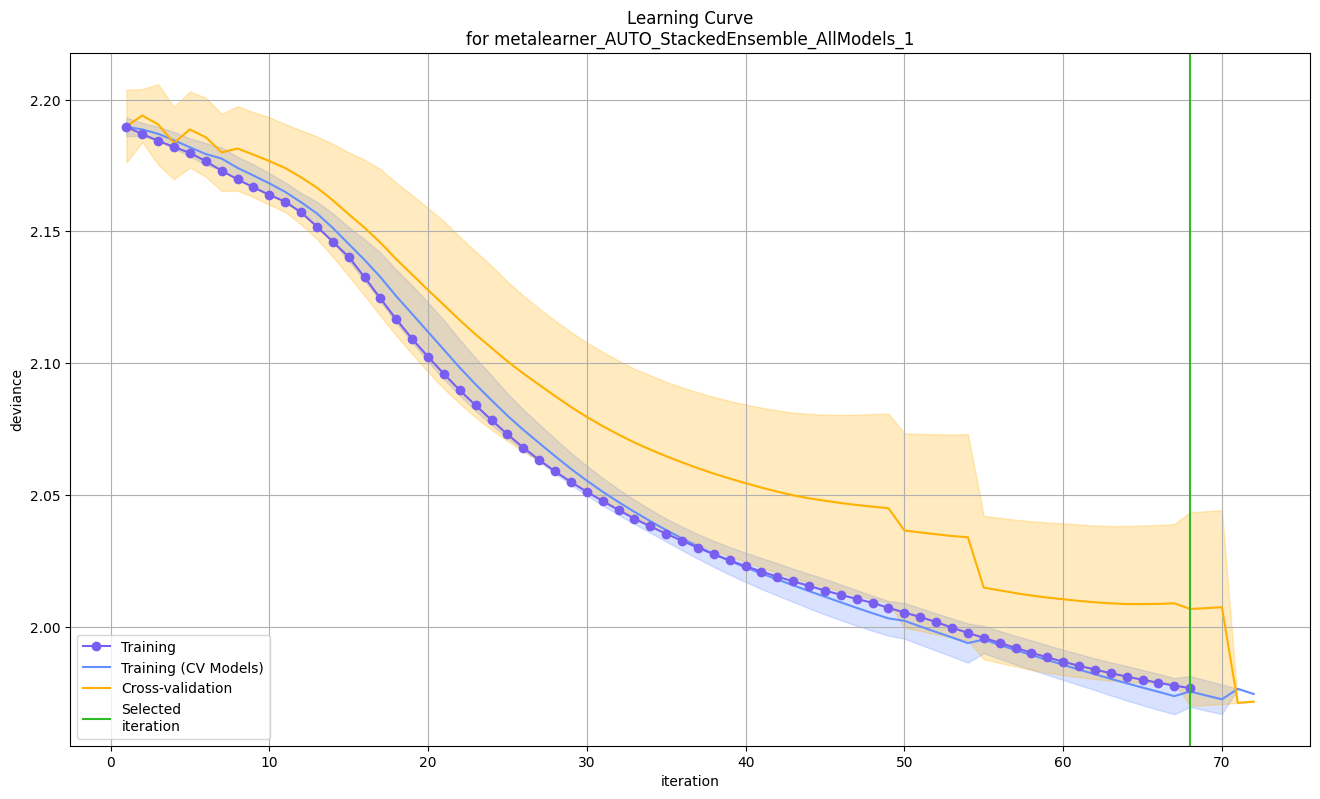

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

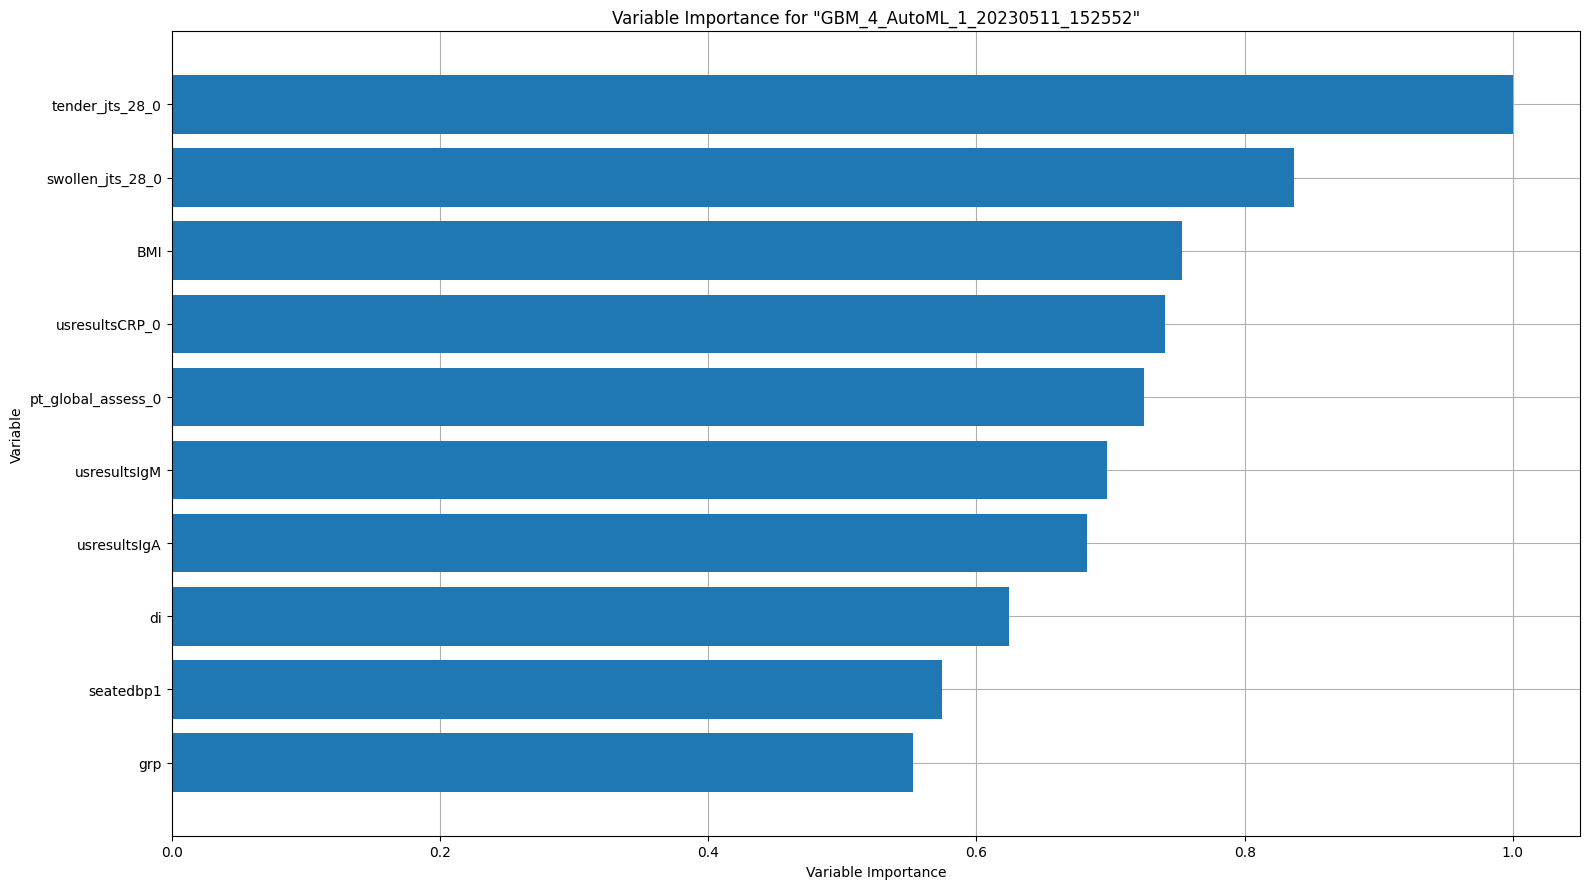

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

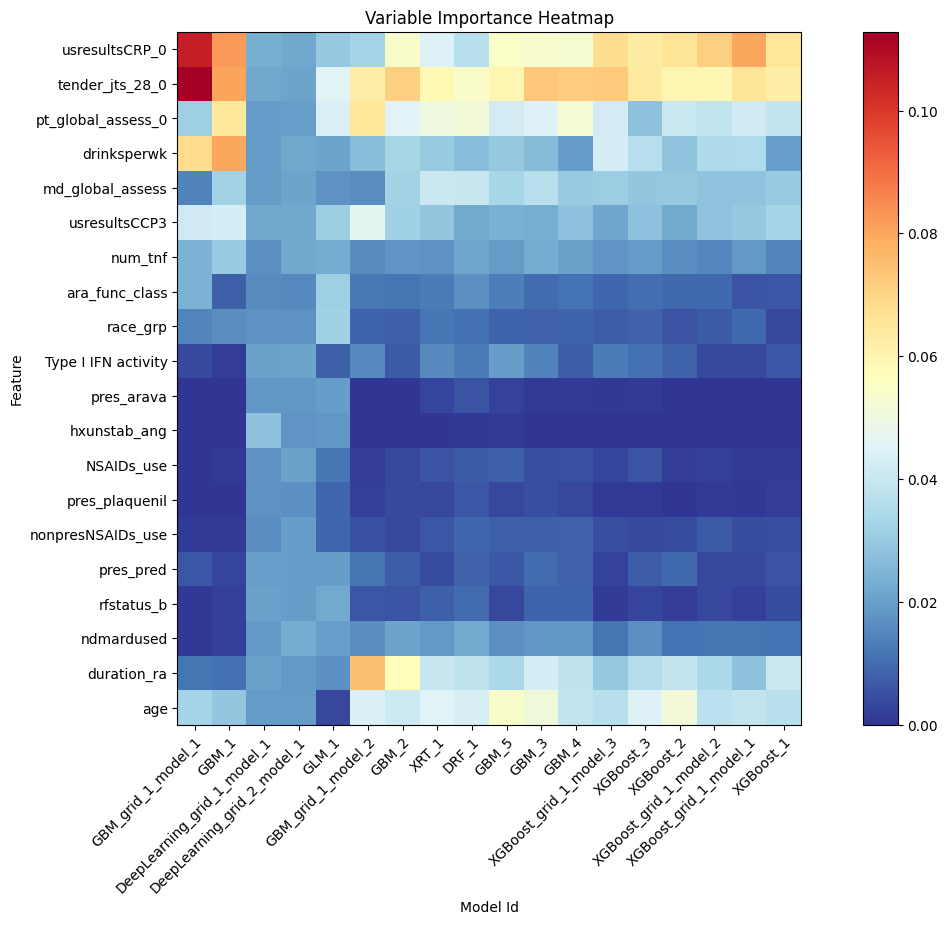

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

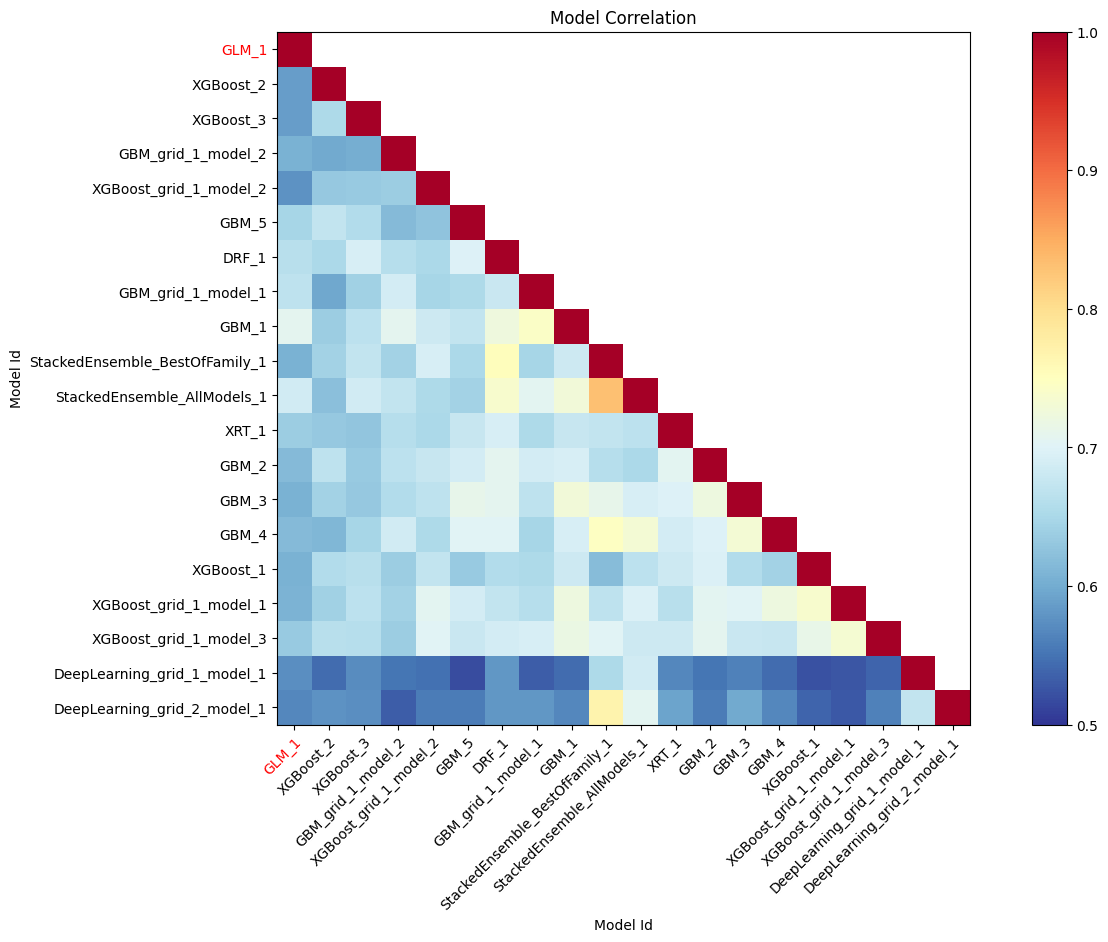

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

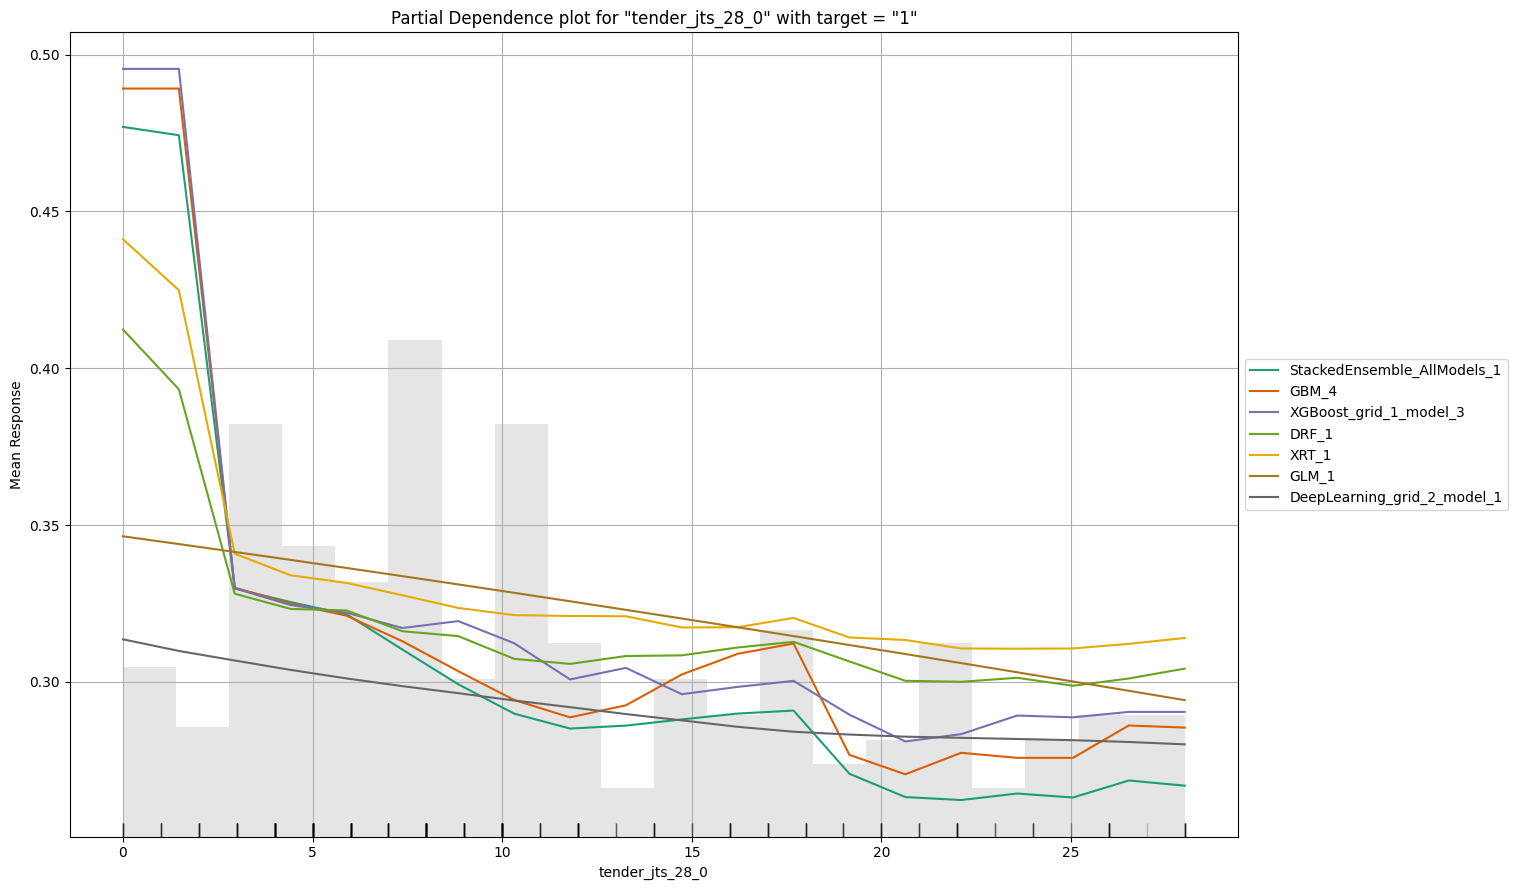

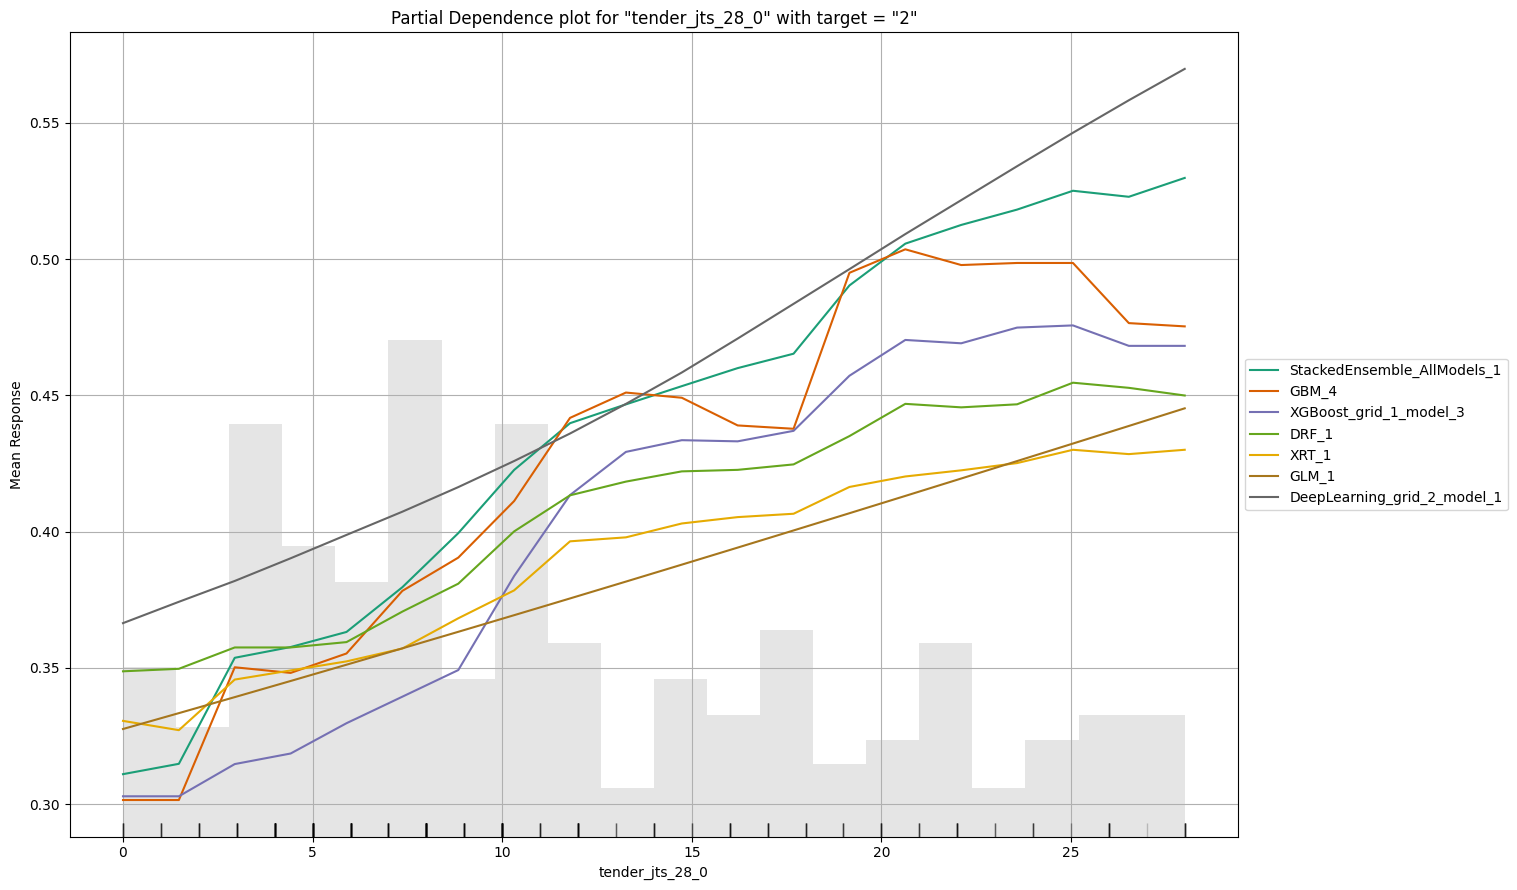

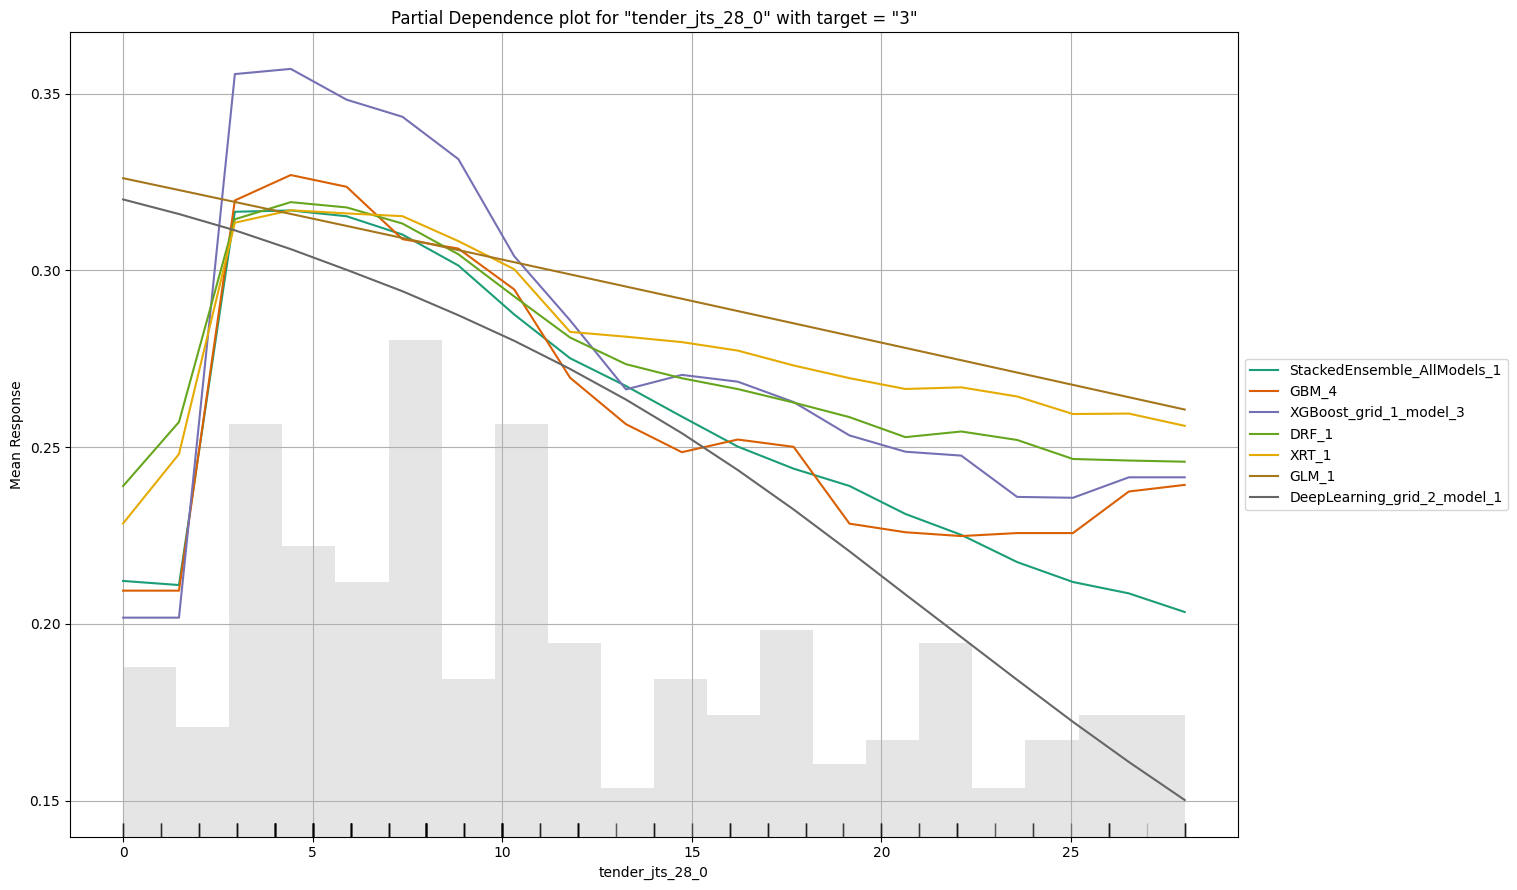

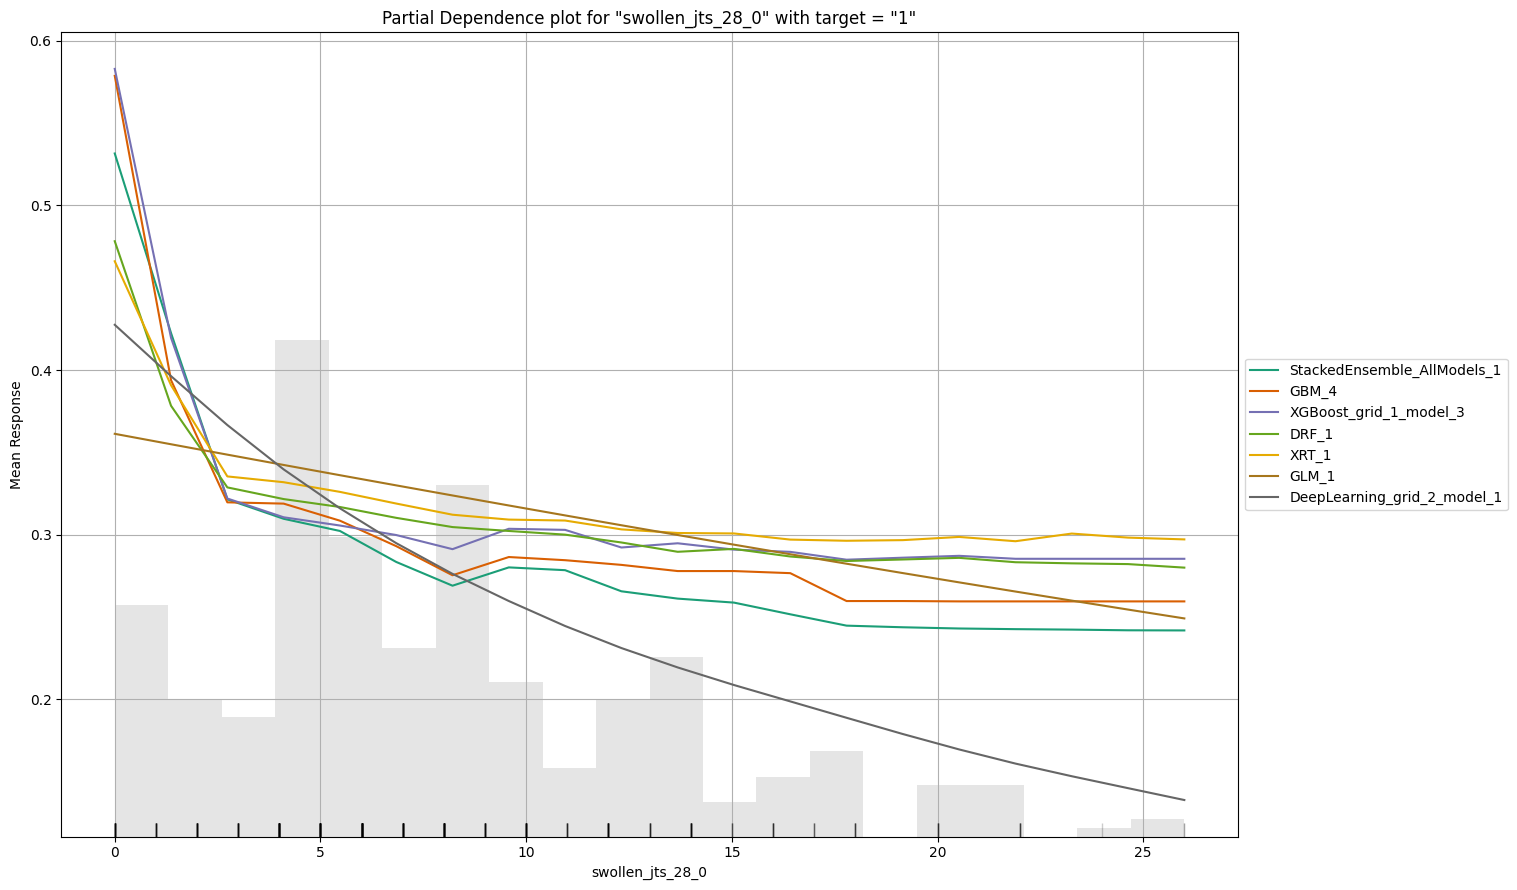

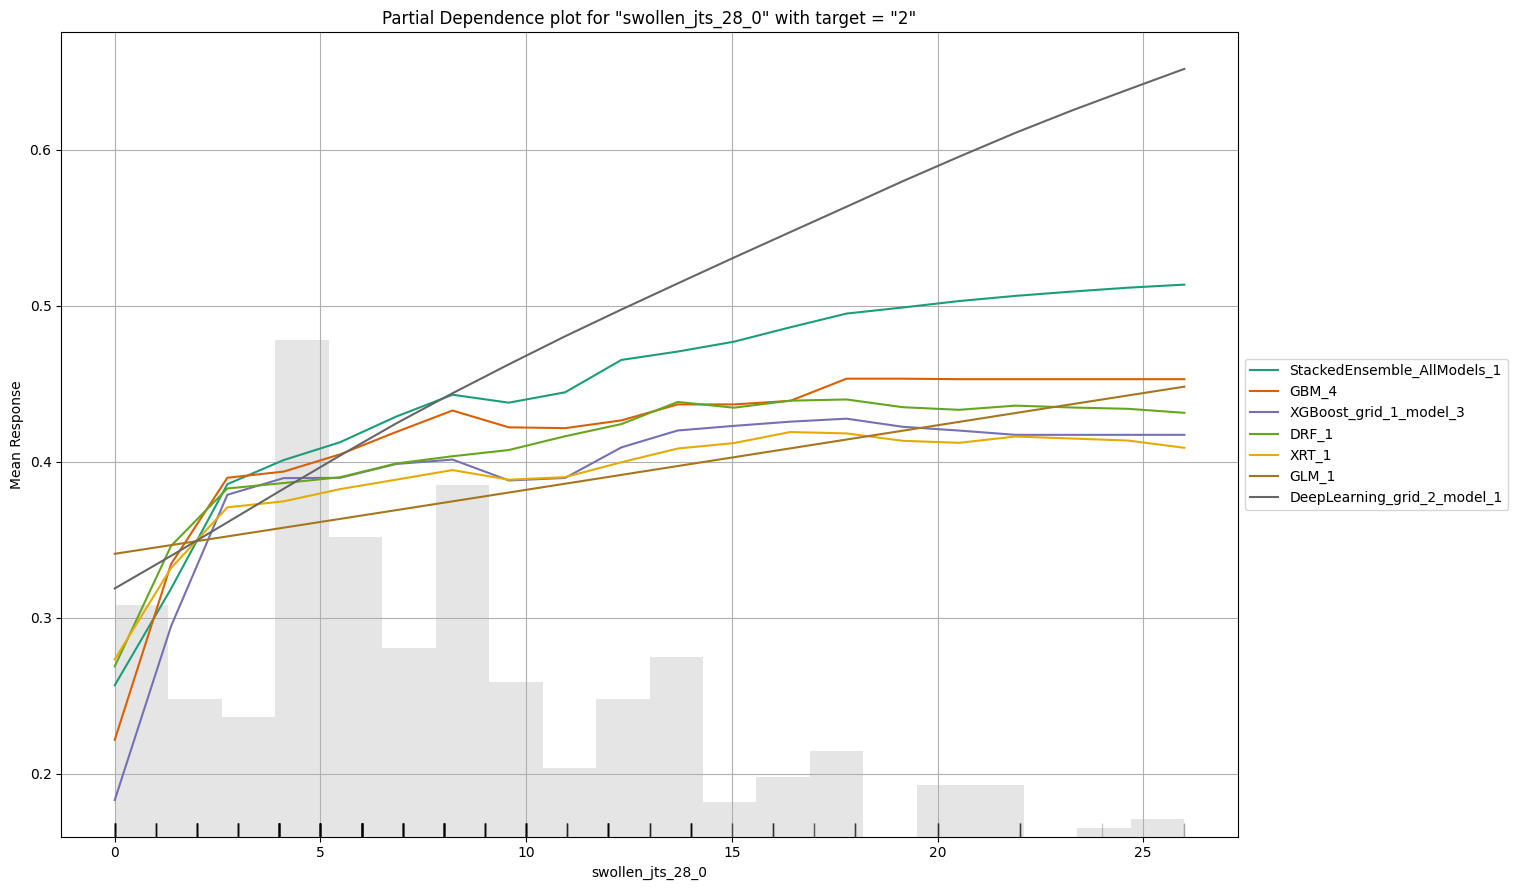

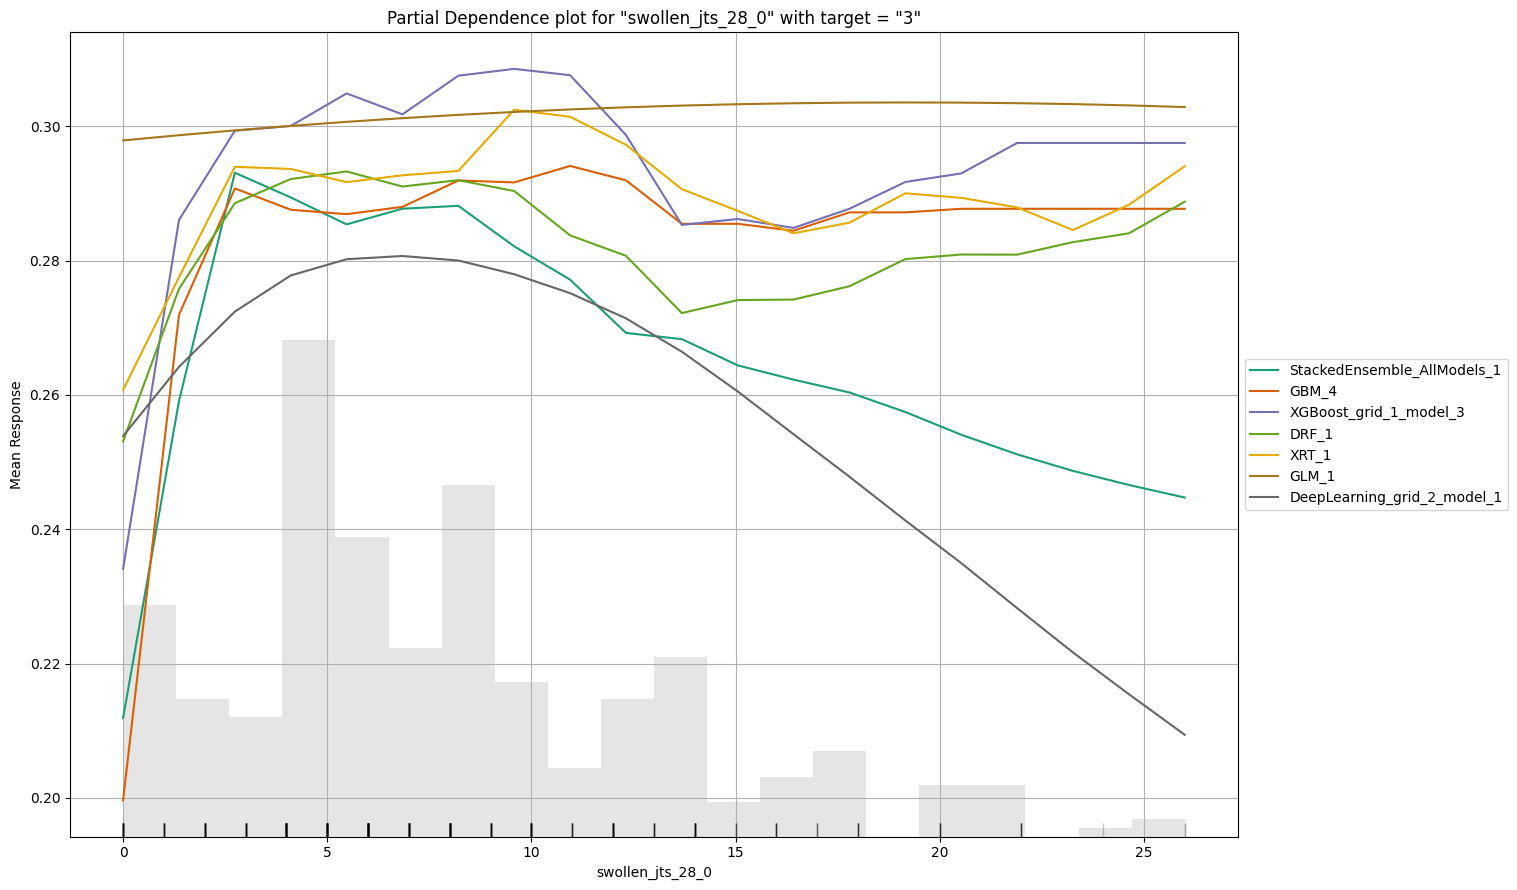

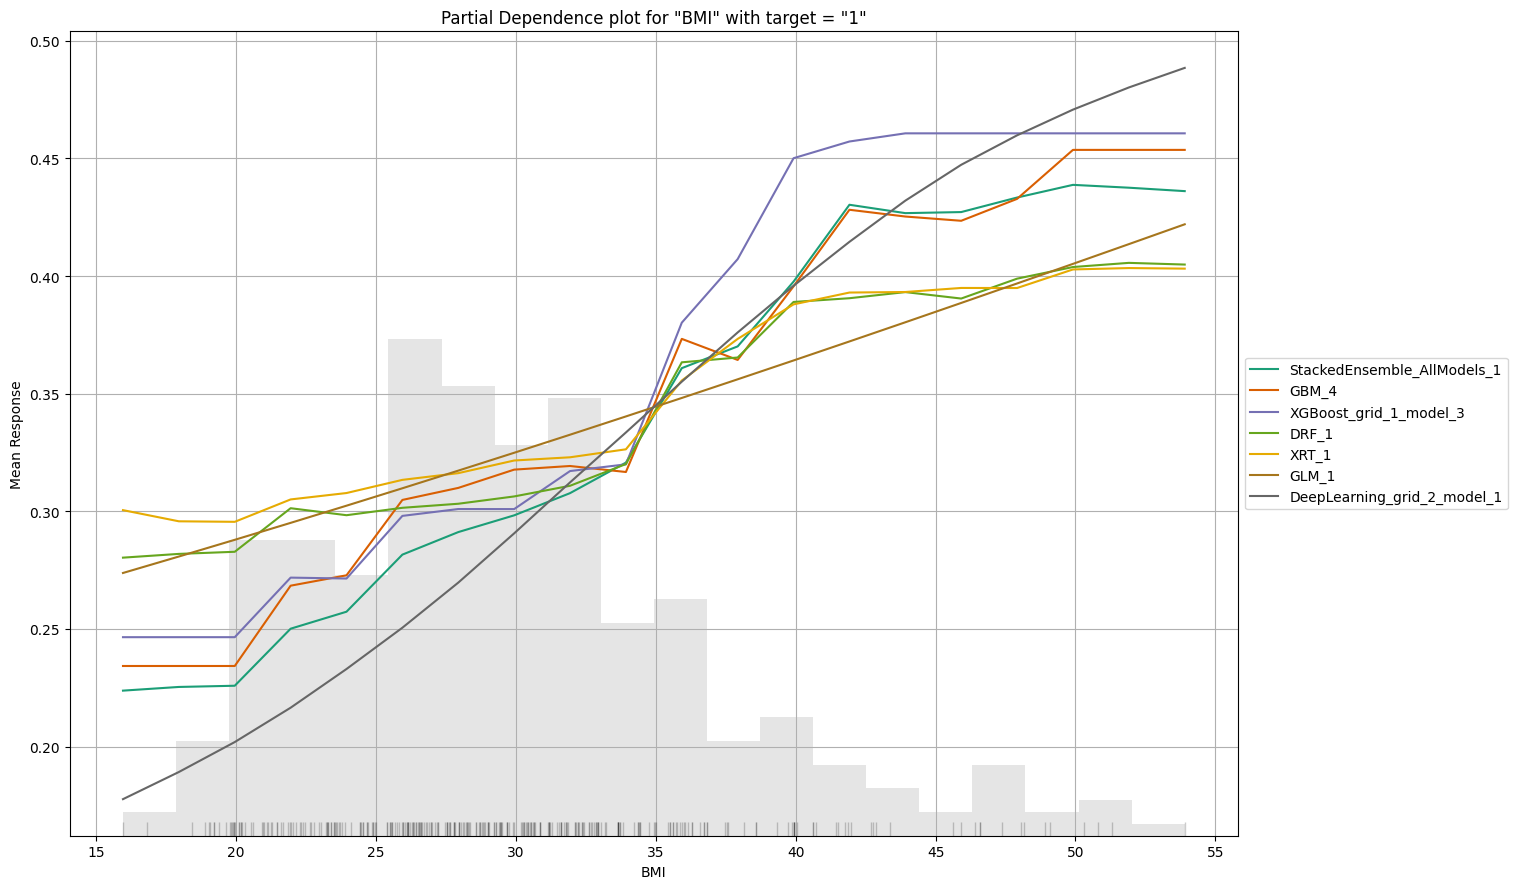

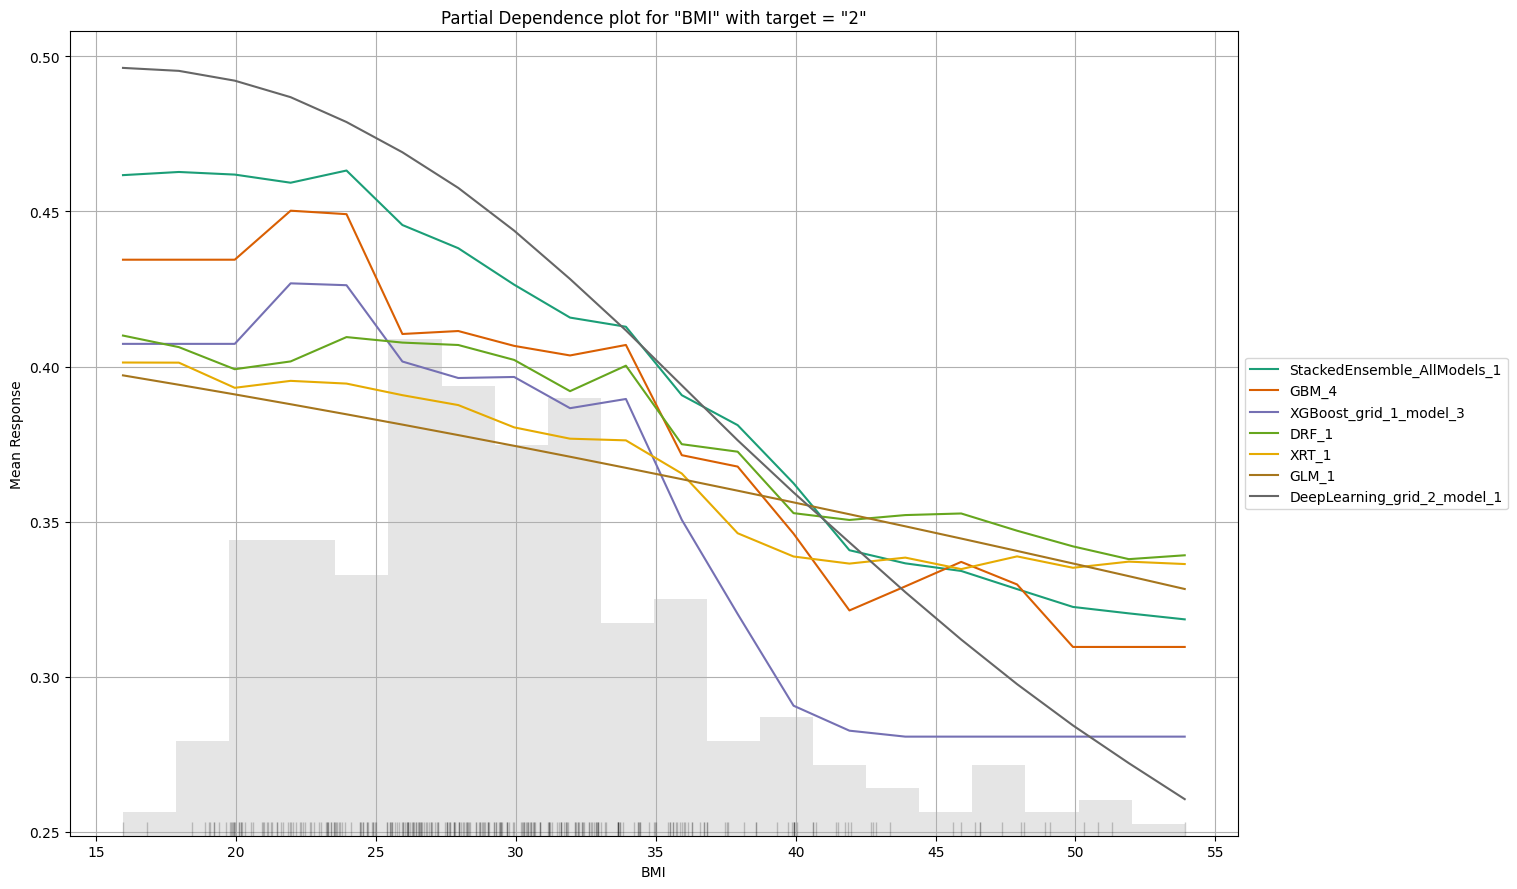

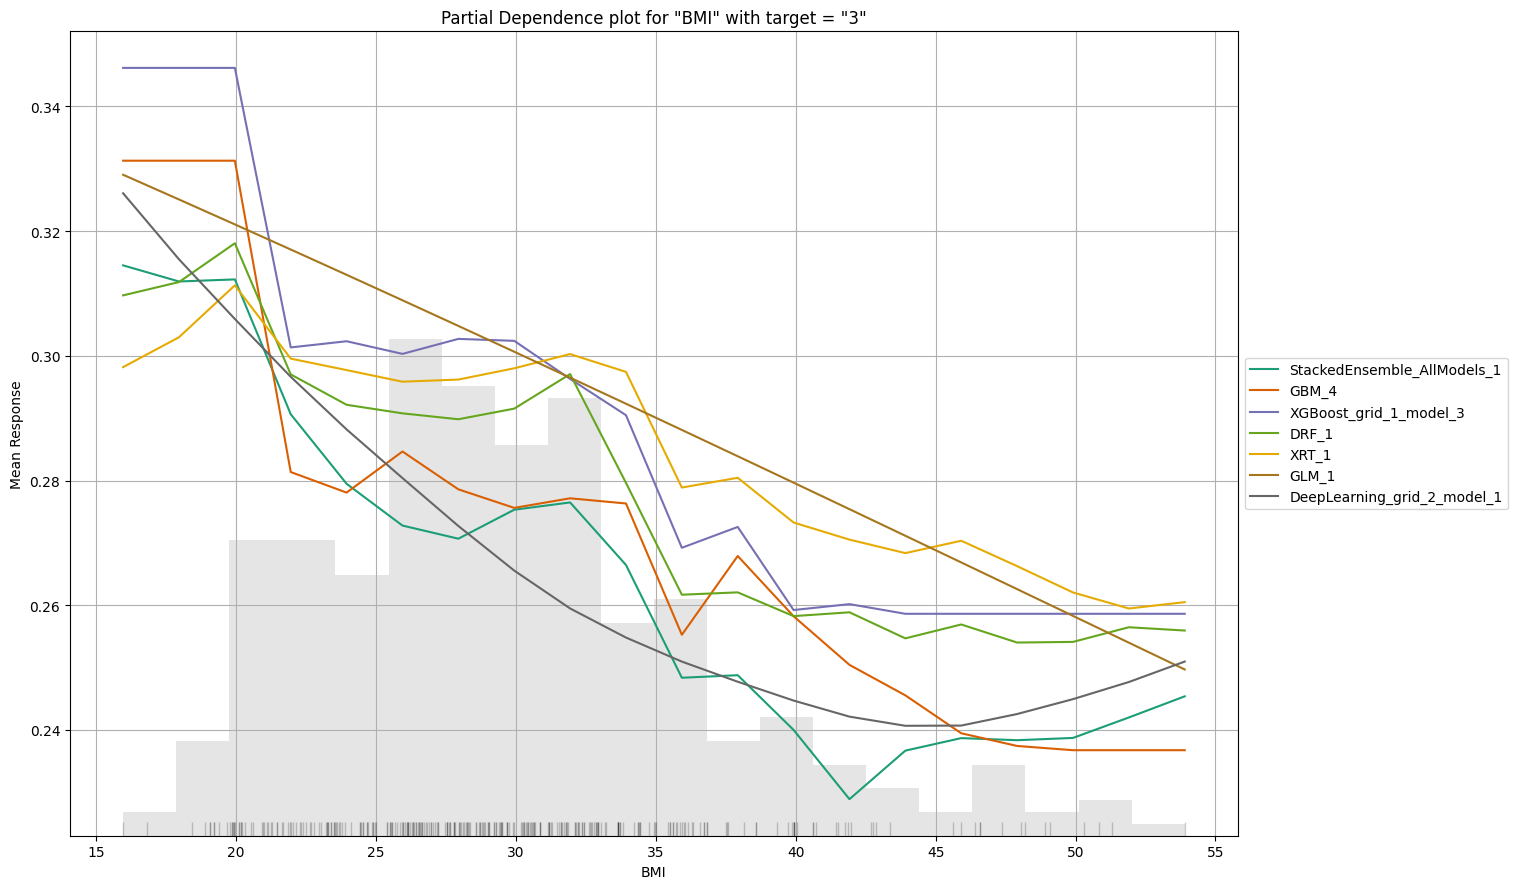

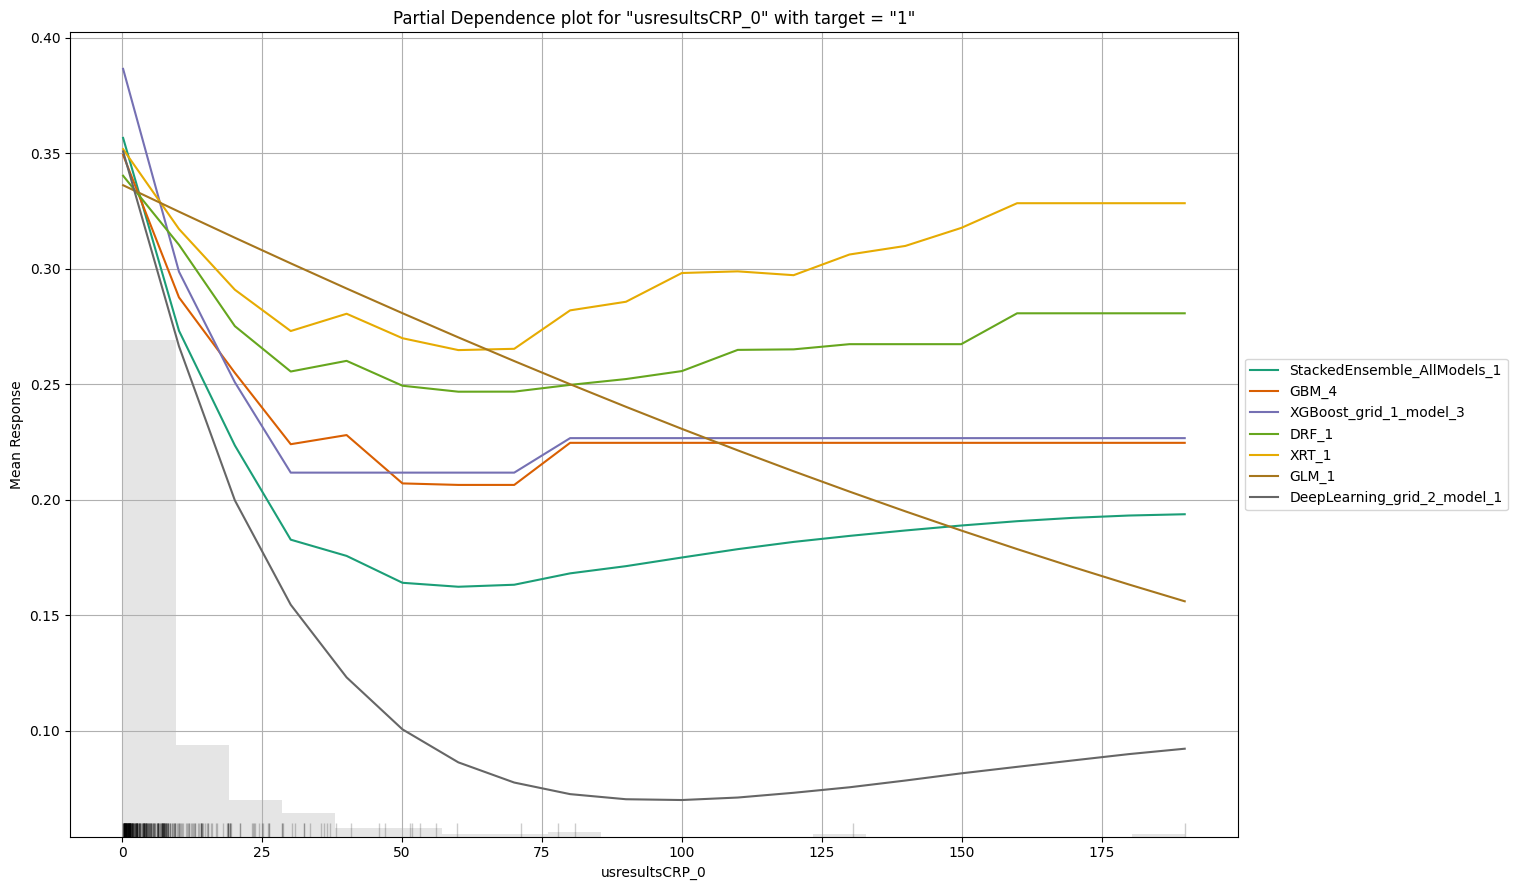

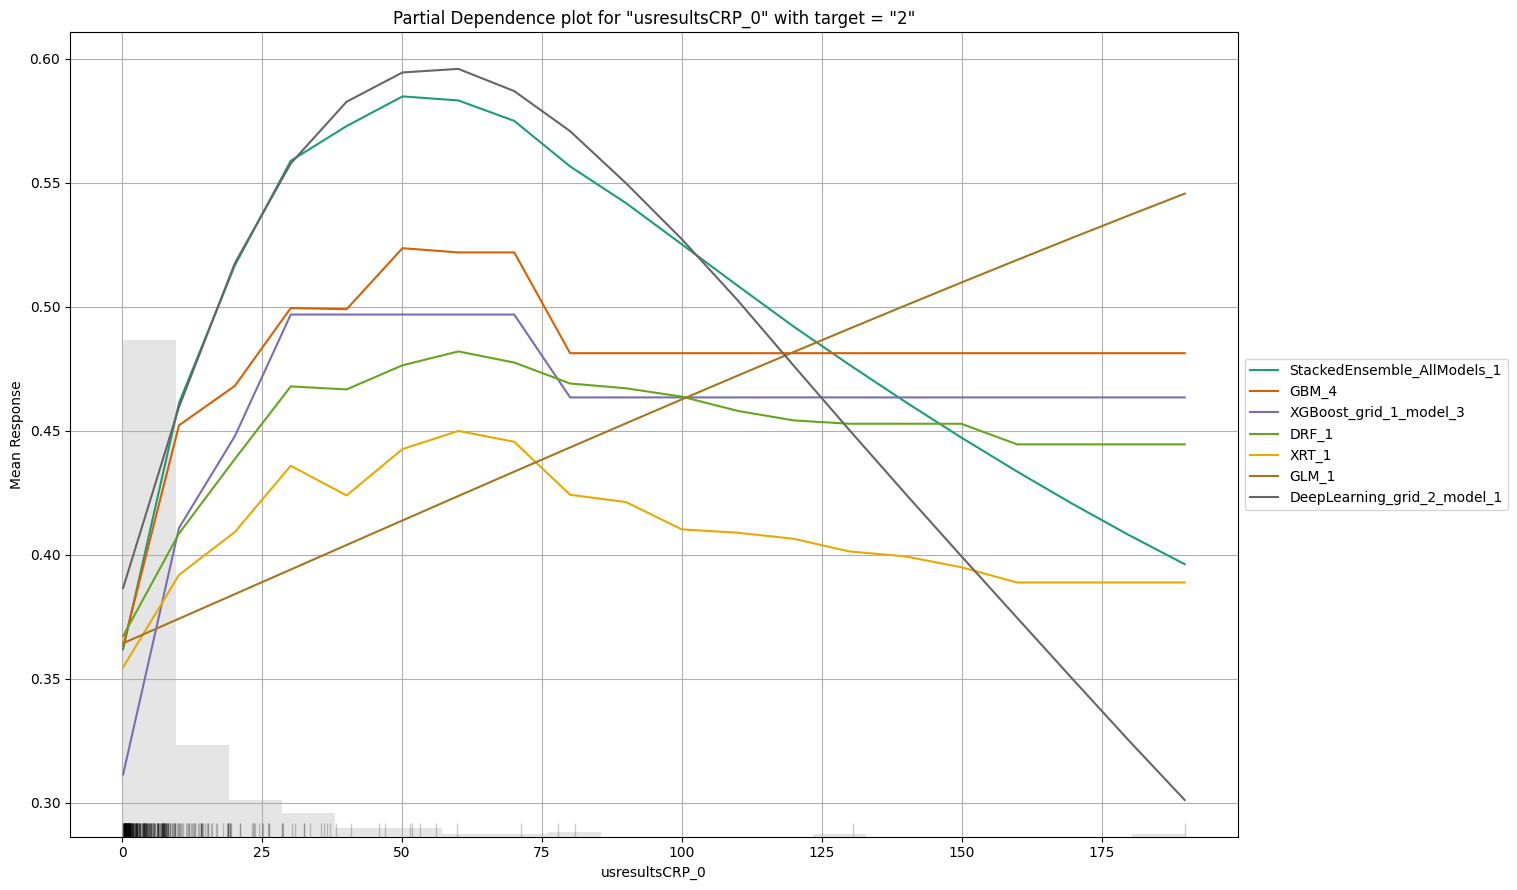

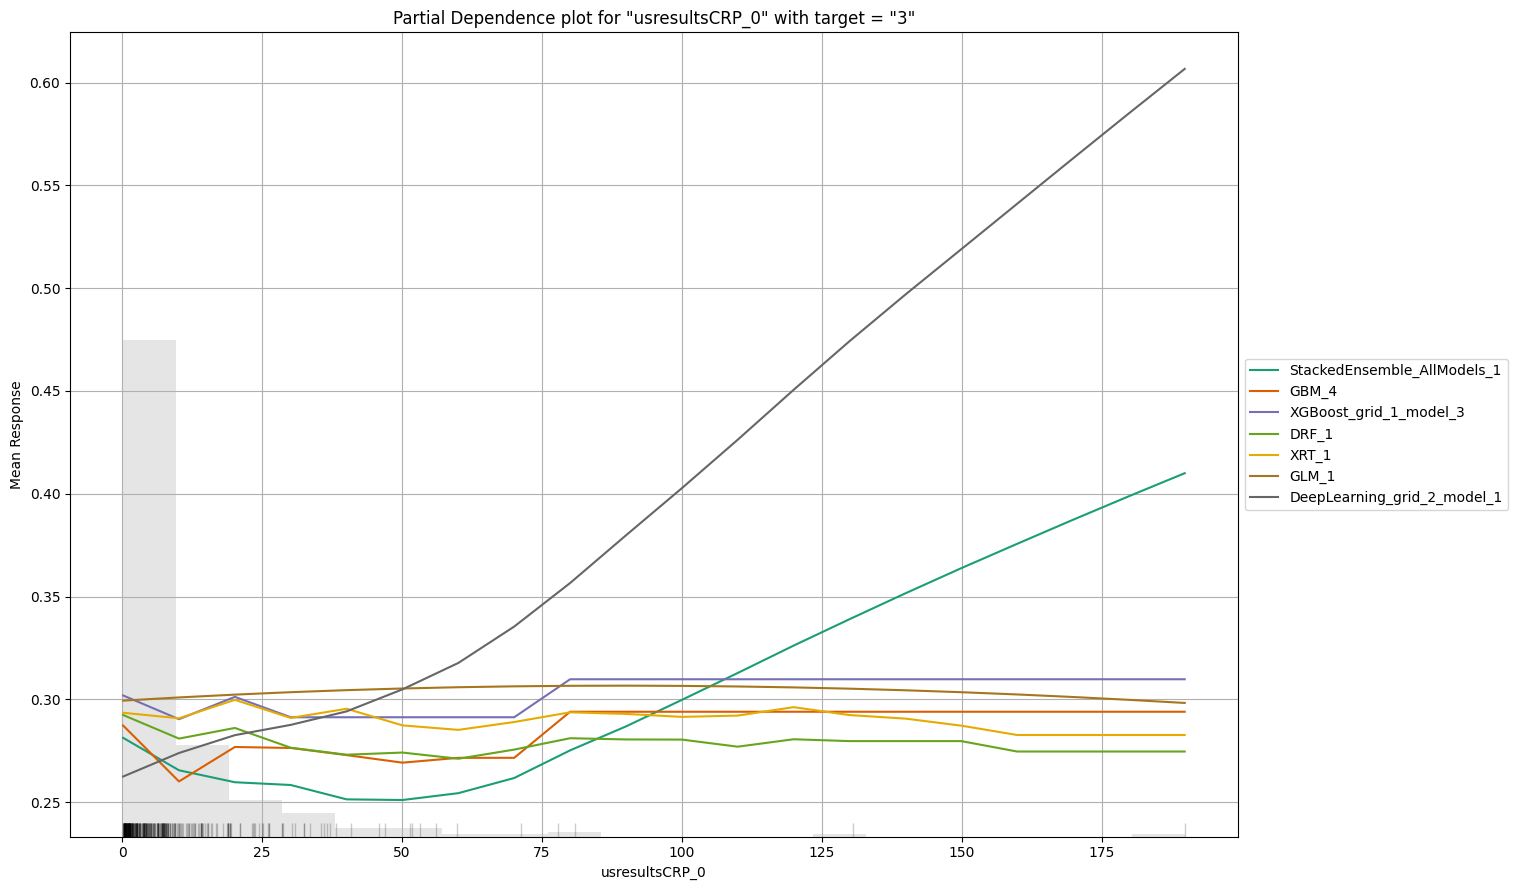

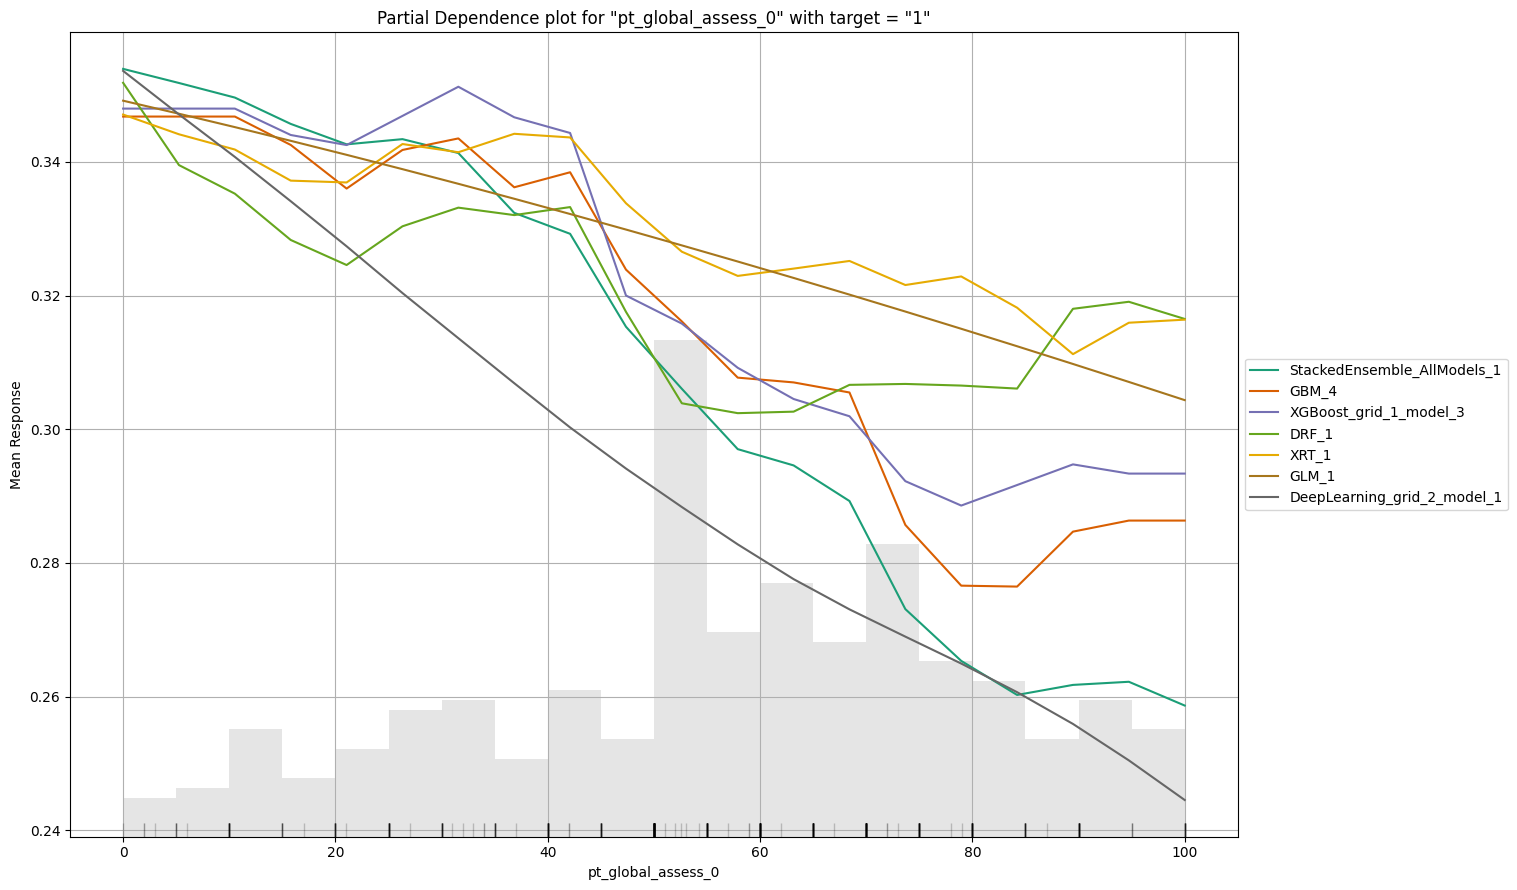

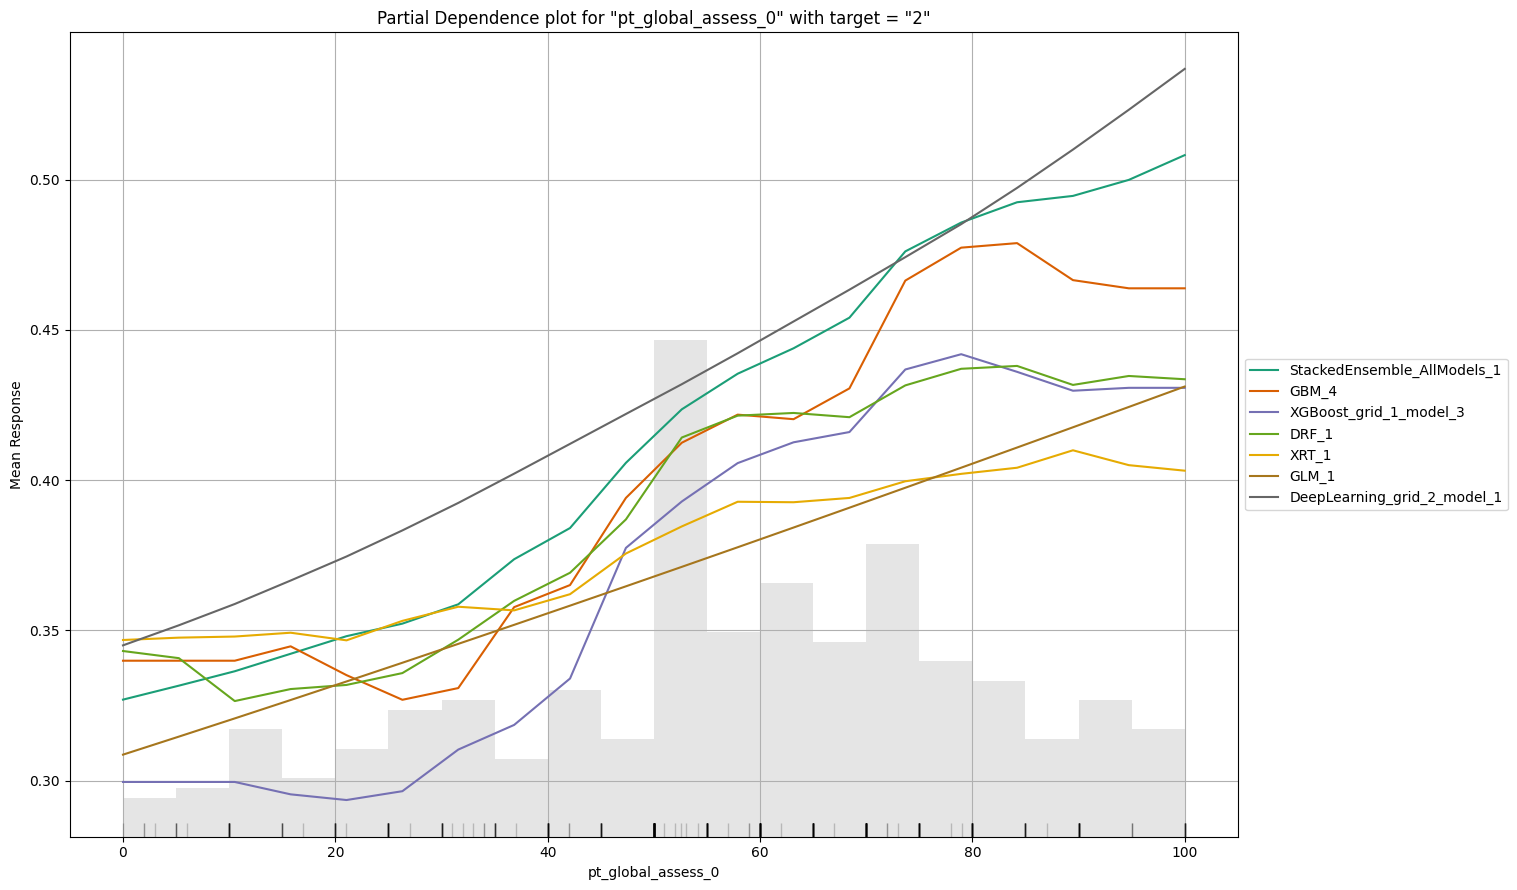

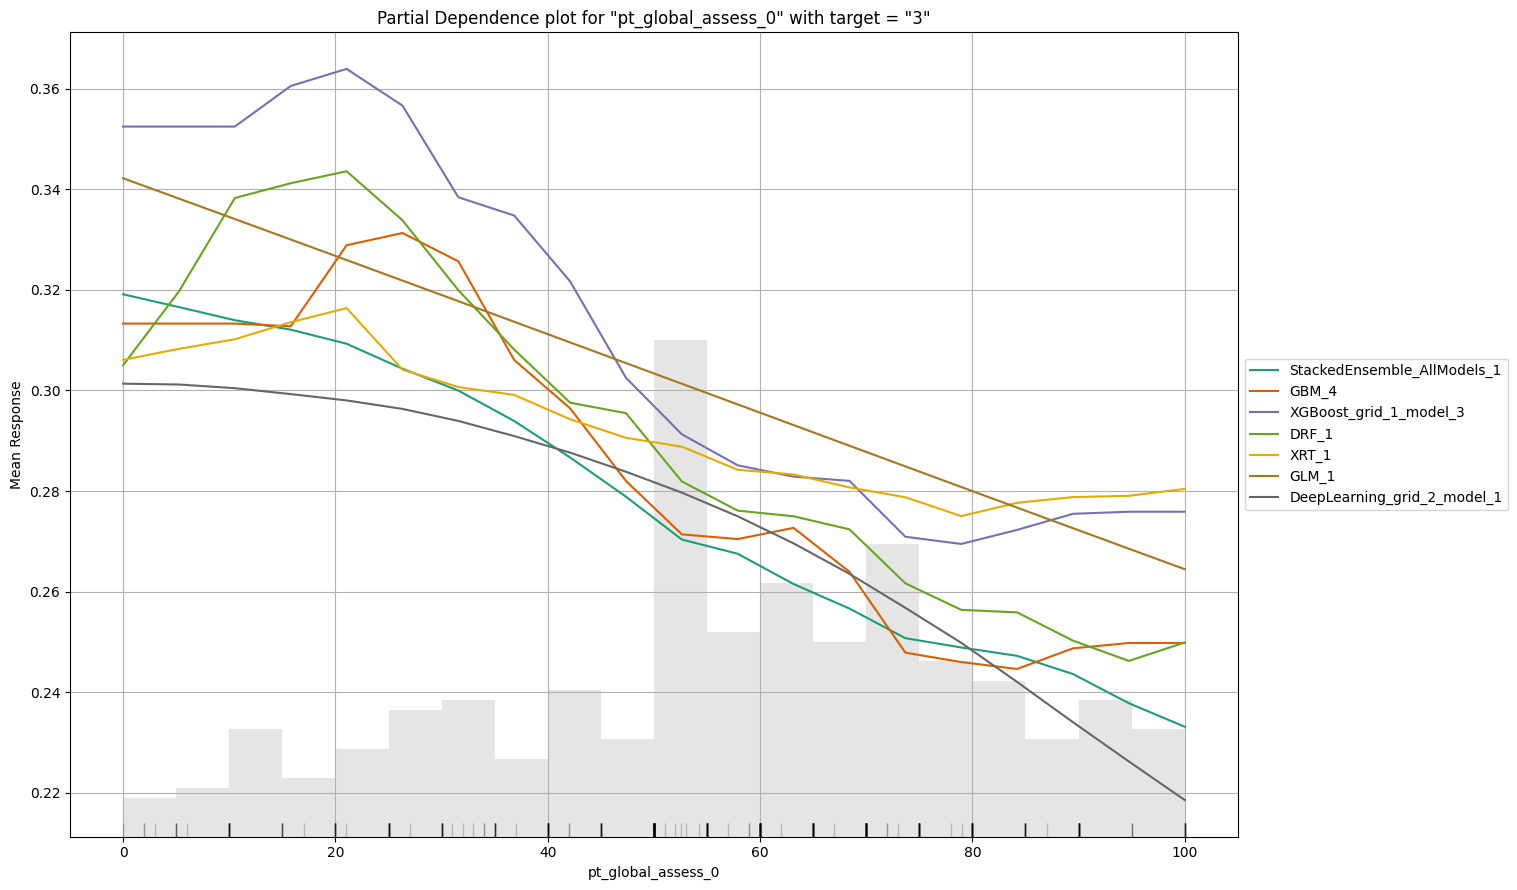

In [32]:
exm = aml.explain(test)


In [33]:
preds = aml.leader.predict(test)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [34]:
df = test.cbind(preds)

#preview
df.head(10)


grp    init_group    age    gender    final_education    race_grp    ethnicity      BMI    height    newsmoker    drinker    drinksperwk    duration_ra    ara_func_class    num_tnf    num_nontnf    ndmardused    rfstatus_b    usresultsRF    usresultsCCP3    hxmi    hxunstab_ang    hxchf    hxother_cv    hxtia    hxstroke    hxcopd    hxhtn    hxdiabetes    hxhld    hx_anycancer    seatedbp1    seatedbp2    pres_mtx    pres_arava    pres_azulfidine    pres_plaquenil    pres_imuran    pres_minocin    pres_pred    nonpresNSAIDs_use    NSAIDs_use    md_global_assess       di    usresultsIgA    usresultsIgG    usresultsIgM    tender_jts_28_0    swollen_jts_28_0    pt_global_assess_0    usresultsCRP_0    Type I IFN activity    response_encoded    predict        p1        p2        p3
-----  ------------  -----  --------  -----------------  ----------  -----------  -------  --------  -----------  ---------  -------------  -------------  ----------------  ---------  ------------  ------------  ------------  -------------  ---------------  ------  --------------  -------  ------------  -------  ----------  --------  -------  ------------  -------  --------------  -----------  -----------  ----------  ------------  -----------------  ----------------  -------------  --------------  -----------  -------------------  ------------  ------------------  -------  --------------  --------------  --------------  -----------------  ------------------  --------------------  ----------------  ---------------------  ------------------  ---------  --------  --------  --------
    4             0     51         0                  0           7     1         20.2204        68            2          1       0.233333              9                 2          1      0                    2             1          339.8            251         0               0        0             0        0           0         0        0             0        0               0          140           90           0             0                  0                 0              0               0            1                    1             0                  70  1.28571             469            1260             114                  8                  10                    90            5.56                 0                          2          2  0.112504  0.791429  0.096067
    6             0     63         0                  0           7     1         20.939         64            0          1       3                     5                 1          1      1                    2             0            8.2             15         0               0        0             0        0           0         0        0             0        0               0          113           68           1             0                  0                 0              0               0            1                    0             1                  35  0                   179            1210             176                  4                   8                    70            0.19                 0                          3          2  0.191325  0.623403  0.185272
    4             0     47         0                  2           7     1         24.8865        64            1          1       1                    22                 1          2      0.233333             1             1          144.7            251         0               0        0             0        0           0         0        0             0        0               0          144           83           0             0                  0                 0              0               0            0                    0             0                  45  0.5                 177            1250             313                  8                   9                    42           15.99                 0                          3          1  0.379427  0.275507  0.345066
    4             0     80         0           

In [35]:
df = h2o.as_list(df)


In [36]:
preds = df[['response_encoded', 'predict']].head(20)
preds

response_encoded  predict
0                  2        2
1                  3        2
2                  3        1
3                  2        2
4                  1        3
5                  1        3
6                  2        2
7                  3        1
8                  2        1
9                  3        1
10                 3        1
11                 3        3
12                 1        1
13                 1        1
14                 3        1
15                 3        2
16                 2        2
17                 1        2
18                 2        2
19                 3        2

In [37]:
!pip install lime
import lime
import lime.lime_tabular

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=676546e880c811e3015162abc2ee7b6bbf72b4dcd684ee7269323b0cf5a9b0d5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [38]:
feature_names = train.columns[0: -1]
feature_names

['grp',
 'init_group',
 'age',
 'gender',
 'final_education',
 'race_grp',
 'ethnicity',
 'BMI',
 'height',
 'newsmoker',
 'drinker',
 'drinksperwk',
 'duration_ra',
 'ara_func_class',
 'num_tnf',
 'num_nontnf',
 'ndmardused',
 'rfstatus_b',
 'usresultsRF',
 'usresultsCCP3',
 'hxmi',
 'hxunstab_ang',
 'hxchf',
 'hxother_cv',
 'hxtia',
 'hxstroke',
 'hxcopd',
 'hxhtn',
 'hxdiabetes',
 'hxhld',
 'hx_anycancer',
 'seatedbp1',
 'seatedbp2',
 'pres_mtx',
 'pres_arava',
 'pres_azulfidine',
 'pres_plaquenil',
 'pres_imuran',
 'pres_minocin',
 'pres_pred',
 'nonpresNSAIDs_use',
 'NSAIDs_use',
 'md_global_assess',
 'di',
 'usresultsIgA',
 'usresultsIgG',
 'usresultsIgM',
 'tender_jts_28_0',
 'swollen_jts_28_0',
 'pt_global_assess_0',
 'usresultsCRP_0',
 'Type I IFN activity']

In [39]:
train_features_numpy = train[feature_names].as_data_frame().values
train_features_numpy

array([[ 4.  ,  0.  , 59.  , ..., 55.  , 17.13,  0.  ],
       [ 2.  ,  1.  , 54.  , ..., 25.  ,  1.64,  0.  ],
       [ 0.  ,  0.  , 67.  , ..., 40.  ,  0.43,  0.  ],
       ...,
       [ 3.  ,  1.  , 61.  , ..., 15.  ,  0.92,  0.  ],
       [ 2.  ,  1.  , 57.  , ..., 50.  , 12.67,  0.  ],
       [ 1.  ,  1.  , 23.  , ..., 93.  ,  3.9 ,  0.  ]])

In [40]:
#define LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(train_features_numpy, 
                                                   feature_names = feature_names,
                                                   mode='classification')

In [41]:
def findPrediction(instance):

 #instance will be in type of numpy
 df = pd.DataFrame(data = instance, columns = feature_names)
 hf = h2o.H2OFrame(df)
 predictions = aml.leader.predict(hf).as_data_frame()
 
 #here predictions object is 3 columned data frame. 1st column is class prediction and others are probabilities
 #lime needs just prediction probabilities
 
 predictions = predictions.iloc[:,1:].values
 return predictions

In [42]:
idx = 100
test_df = test.as_data_frame()
test_numpy = test_df.iloc[idx].values[0:-1]

In [43]:

test_numpy = np.delete(test_numpy, np.where(test_numpy == 'No Response'))
test_numpy


<ipython-input-43-a33a13b8d92e>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  test_numpy = np.delete(test_numpy, np.where(test_numpy == 'No Response'))


array([4.00000000e+00, 0.00000000e+00, 5.60000000e+01, 1.00000000e+00,
       2.00000000e+00, 7.00000000e+00, 1.00000000e+00, 3.57332493e+01,
       6.90000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.20000000e+01, 1.00000000e+00, 3.00000000e+00, 2.00000000e+00,
       2.00000000e+00, 1.00000000e+00, 7.50000000e+02, 2.51000000e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20000000e+02,
       8.00000000e+01, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.00000000e+01, 1.00000000e+00,
       2.99000000e+02, 1.17000000e+03, 1.42000000e+02, 1.00000000e+01,
       3.00000000e+00, 9.00000000e+01, 2.57000000e+00, 0.00000000e+00])

In [44]:
exp = explainer.explain_instance(test_numpy, 
                                 findPrediction, 
                                 num_features = len(feature_names))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [45]:
exp.show_in_notebook(show_table=True, show_all=True)


In [46]:
exp.as_list()


[('pres_minocin <= 0.00', 0.2592006862178716),
 ('hxstroke <= 0.00', -0.20472390128863355),
 ('hxtia <= 0.00', 0.18541210372525532),
 ('pres_azulfidine <= 0.00', -0.10295171541595864),
 ('swollen_jts_28_0 <= 4.00', -0.09690853125701043),
 ('hxcopd <= 0.00', 0.09329315066701674),
 ('usresultsRF > 110.20', 0.09306597041612596),
 ('pres_imuran <= 0.00', -0.09286638451766742),
 ('hx_anycancer <= 0.00', -0.08372856488935472),
 ('pt_global_assess_0 > 70.00', 0.07646518719706444),
 ('BMI > 34.38', -0.07567869563539786),
 ('0.00 < rfstatus_b <= 1.00', -0.07354470022686477),
 ('ara_func_class <= 1.00', -0.07027791355366682),
 ('1.54 < usresultsCRP_0 <= 4.09', -0.0680828551188805),
 ('0.00 < final_education <= 2.00', -0.0559539746257611),
 ('num_tnf > 2.00', 0.0553342319001192),
 ('nonpresNSAIDs_use <= 0.00', -0.045631335236839),
 ('pres_arava <= 0.00', -0.04363396026221562),
 ('hxunstab_ang <= 0.00', -0.040908737055682265),
 ('gender > 0.00', 0.0407886785270519),
 ('newsmoker <= 1.00', -0.04036